## Assignment 7 

**Dataset Generation (Binary Patterns of Letters)**

The data consists of random binary images of letters A, B, and C. Each letter is manually specified as a 5×6 grid (30 pixels), in which 1 is used to mark black pixels (letter area) and 0 is used to mark white pixels (background). The patterns are flattened into 1D arrays of size 30 and put together into a matrix X of features. Corresponding tags 0, 1, and 2 are used for A, B, and C respectively. This method does not require the use of external files and provides complete control over training data.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def get_dataset():
    A = np.array([
        [0,1,1,1,0,
         1,0,0,0,1,
         1,1,1,1,1,
         1,0,0,0,1,
         1,0,0,0,1,
         0,0,0,0,0]
    ])

    B = np.array([
        [1,1,1,0,0,
         1,0,0,1,0,
         1,1,1,0,0,
         1,0,0,1,0,
         1,1,1,0,0,
         0,0,0,0,0]
    ])

    C = np.array([
        [0,1,1,1,1,
         1,0,0,0,0,
         1,0,0,0,0,
         1,0,0,0,0,
         0,1,1,1,1,
         0,0,0,0,0]
    ])

    X = np.vstack([A, B, C])
    y = np.array([0, 1, 2])
    return X, y

**One-Hot Encoding of Labels**

The target labels (0 for A, 1 for B, 2 for C) are encoded into one-hot vector representations. One-hot encoding maps every class label to a binary vector with a 1 in the class position and 0s elsewhere. For instance, label 1 is encoded as [0, 1, 0]. This is the format that the cross-entropy loss function needs and how to compare predictions from the softmax output.

In [16]:
def one_hot_encode(y, num_classes=3):
    return np.eye(num_classes)[y]

**Activation Functions**

Two activation functions are employed in the network. The sigmoid function is utilized in the hidden layer to provide non-linearity so that the network is capable of learning intricate patterns. During backpropagation, its derivative is utilized to calculate the gradient. The softmax function is employed in the output layer, which is used to transform raw scores into probabilities for every class (A, B, C). This facilitates understanding the prediction of the model and calculating the loss.

In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)


**Weight and Bias Initialization**

Weights (W1, W2) and biases (b1, b2) for the network are randomly initialized with small values. W1 and b1 are for the input-to-hidden layer, and W2 and b2 are for the hidden-to-output layer. Random initialization breaks symmetry so that each neuron can learn unique patterns. Initialization is essential for successful learning during training.

In [22]:
def initialize_weights(input_size, hidden_size, output_size):
    np.random.seed(42)
    W1 = np.random.randn(input_size, hidden_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size)
    b2 = np.zeros((1, output_size))
    return W1, b1, W2, b2

**Forward Propagation**

In forward pass, the input data goes through the network to generate an output. The input is first multiplied by W1, added with b1, and then fed through the sigmoid function to generate hidden layer activations. These hidden outputs are next fed into the second layer where they are mixed with W2 and b2, and fed through the softmax function to yield the final prediction probabilities. This enables the network to calculate an output from the existing weights.

In [25]:
def forward(X, W1, b1, W2, b2):
    z1 = np.dot(X, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

**Loss Function**

The model uses cross-entropy loss, which is standard for classification tasks. It compares the predicted probabilities (from softmax) with the true one-hot encoded labels. The function penalizes incorrect and overconfident predictions more heavily. This loss is averaged over all training examples and used to guide the learning process during backpropagation.

In [28]:
def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)])
    return np.sum(log_likelihood) / m

**Backpropagation**

Backpropagation is used to compute gradients of the loss with respect to each parameter (weights and biases). It starts at the output layer and works backward through the network, applying the chain rule of calculus. The gradients of softmax and sigmoid are used to calculate how much each parameter contributed to the final loss. These gradients are essential for updating the weights in the correct direction to minimize loss.

In [31]:
def backward(X, y_true, z1, a1, a2, W2):
    m = y_true.shape[0]
    dz2 = a2 - y_true
    dW2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0, keepdims=True) / m

    dz1 = np.dot(dz2, W2.T) * sigmoid_derivative(z1)
    dW1 = np.dot(X.T, dz1) / m
    db1 = np.sum(dz1, axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2

**Gradient Descent and Training Loop**

The model is trained with a loop that repeats for a specified number of epochs. At every epoch, the model goes through forward propagation to obtain predictions, calculates the loss, performs backpropagation to obtain gradients, and updates weights and biases via gradient descent. The loss is tracked at every epoch to monitor training. This loop assists the network in learning from its mistakes incrementally.

In [34]:
def train(X, y, hidden_size=10, epochs=500, lr=0.1):
    input_size = X.shape[1]
    output_size = y.shape[1]
    W1, b1, W2, b2 = initialize_weights(input_size, hidden_size, output_size)

    losses = []
    for epoch in range(epochs):
        z1, a1, z2, a2 = forward(X, W1, b1, W2, b2)
        loss = compute_loss(y, a2)
        losses.append(loss)

        dW1, db1, dW2, db2 = backward(X, y, z1, a1, a2, W2)

        # Update weights
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
    return W1, b1, W2, b2, losses

**Visualization of Training Progress**

Training procedure is visualized by matplotlib for plotting loss with respect to epochs. This graph indicates if the model is learning — the loss should decrease uniformly. A flat or rising loss indicates issues with the model or data, but a downward slope means good learning.

In [37]:
def predict(X, W1, b1, W2, b2):
    _, _, _, a2 = forward(X, W1, b1, W2, b2)
    return np.argmax(a2, axis=1)

**Model Evaluation and Image Display**

The model is then tested after training on the same input data to ensure that it makes the correct prediction for the letters A, B, and C. For every input pattern, the network provides the predicted label, which is matched with the actual label. The respective binary image is plotted using imshow() from matplotlib so that visual verification may be made of whether the prediction matches the input letter. This last step finishes illustrating a neural network constructed from scratch.

Epoch 0, Loss: 1.8162
Epoch 50, Loss: 0.3225
Epoch 100, Loss: 0.1423
Epoch 150, Loss: 0.0858
Epoch 200, Loss: 0.0610
Epoch 250, Loss: 0.0471
Epoch 300, Loss: 0.0383
Epoch 350, Loss: 0.0322
Epoch 400, Loss: 0.0277
Epoch 450, Loss: 0.0243


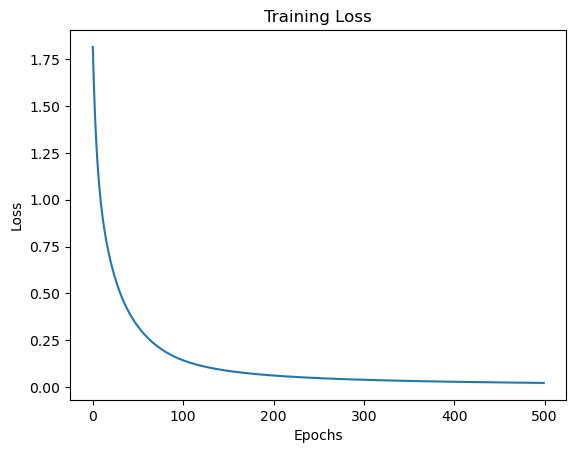

True: 0, Predicted: 0


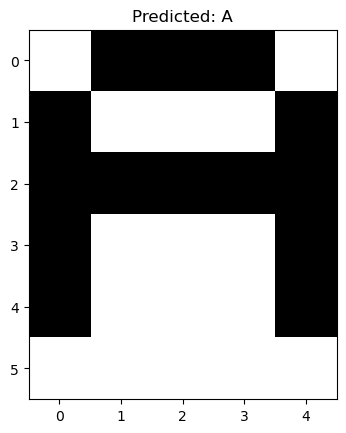

True: 1, Predicted: 1


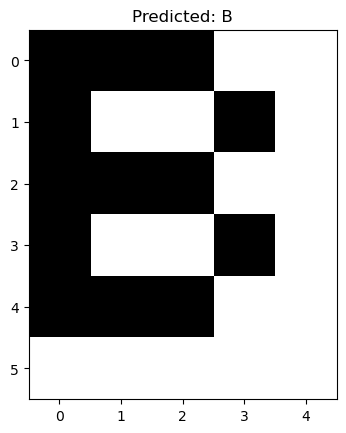

True: 2, Predicted: 2


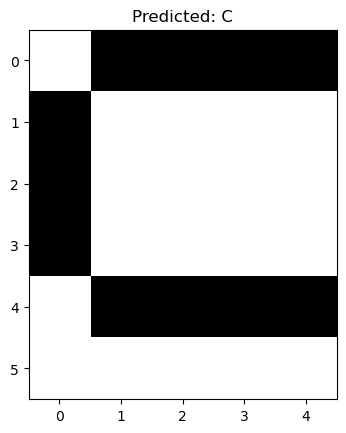

In [40]:

X_raw, y_raw = get_dataset()
X = X_raw
y = one_hot_encode(y_raw)

W1, b1, W2, b2, losses = train(X, y)

# Plot loss curve
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Test prediction
preds = predict(X, W1, b1, W2, b2)
for i in range(len(preds)):
    print(f"True: {y_raw[i]}, Predicted: {preds[i]}")
    plt.imshow(X_raw[i].reshape(6, 5), cmap='Greys')
    plt.title(f"Predicted: {['A','B','C'][preds[i]]}")
    plt.show()
